In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from copy import deepcopy

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.base import TransformerMixin, BaseEstimator

In [2]:
input_dirs = {
    "mc": "/work/gallim/devel/CQRRelatedStudies/NormalizingFlow/samples/mc_uncorr/DYJetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8/nominal",
    "data": "/work/gallim/devel/CQRRelatedStudies/NormalizingFlow/samples/data/DoubleEG/nominal"
}

input_dir = input_dirs["mc"]
files_mc = [f"{input_dir}/{f}" for f in os.listdir(input_dir)][:100]
df_mc = dd.read_parquet(files_mc).compute()
df_mc = df_mc[np.abs(df_mc.probe_eta) < 1.4442]

input_dir = input_dirs["data"]
files_data = [f"{input_dir}/{f}" for f in os.listdir(input_dir)][:100]
df_data = dd.read_parquet(files_data).compute()
df_data = df_data[np.abs(df_data.probe_eta) < 1.4442]

In [3]:
df_mc.columns

Index(['tag_chargedHadronIso', 'tag_eCorr', 'tag_energyErr', 'tag_energyRaw',
       'tag_esEffSigmaRR', 'tag_esEnergyOverRawE', 'tag_eta', 'tag_etaWidth',
       'tag_hoe', 'tag_mass', 'tag_mvaID_Fall17V1p1', 'tag_pfChargedIsoPFPV',
       'tag_pfChargedIsoWorstVtx', 'tag_pfPhoIso03', 'tag_pfRelIso03_all',
       'tag_pfRelIso03_chg', 'tag_phi', 'tag_phiWidth', 'tag_pt', 'tag_r9',
       'tag_s4', 'tag_sieie', 'tag_sieip', 'tag_trkSumPtHollowConeDR03',
       'tag_x_calo', 'tag_y_calo', 'tag_z_calo', 'tag_charge', 'tag_cutBased',
       'tag_cutBased_Fall17V1Bitmap', 'tag_electronIdx', 'tag_jetIdx',
       'tag_pdgId', 'tag_vidNestedWPBitmap', 'tag_electronVeto',
       'tag_isScEtaEB', 'tag_isScEtaEE', 'tag_mvaID_WP80', 'tag_mvaID_WP90',
       'tag_pixelSeed', 'tag_seedGain', 'tag_genPartIdx', 'tag_genPartFlav',
       'tag_cleanmask', 'tag_electronIdxG', 'tag_genPartIdxG', 'tag_jetIdxG',
       'tag_fixedGridRhoAll', 'tag_mvaID', 'probe_chargedHadronIso',
       'probe_eCorr', 'pro

In [4]:
class MaskMixin:
    """Mixin class for masking values in a numpy array"""

    def __init__(self, mask_lower_bound=None, mask_upper_bound=None):
        self.mask_lower_bound = mask_lower_bound
        self.mask_upper_bound = mask_upper_bound

    def apply_mask(self, arr):
        mask = np.ones(arr.shape[0], dtype=bool)
        if self.mask_lower_bound is not None:
            mask = mask & (arr >= np.asarray(self.mask_lower_bound)).reshape(-1)
        if self.mask_upper_bound is not None:
            mask = mask & (arr <= np.asarray(self.mask_upper_bound)).reshape(-1)
        return mask


class Smearer(TransformerMixin, BaseEstimator, MaskMixin):
    def __init__(self, kind, mask_lower_bound=None, mask_upper_bound=None):
        if kind not in ["gaus", "uniform"]:
            raise ValueError
        self.kind = kind
        self.mask_lower_bound = mask_lower_bound
        self.mask_upper_bound = mask_upper_bound

    def get_half_distances(self, arr):
        diffs = np.diff(arr)
        half_diffs = diffs / 2
        result = np.concatenate(
            (
                [arr[0] - half_diffs[0]],
                arr[:-1] + half_diffs,
                [arr[-1] + half_diffs[-1]],
            )
        )
        return result

    def count_occurrences(self, arr):
        unique_values = np.unique(arr).astype("int64")
        counts = np.bincount(arr.astype("int64")[:, 0])
        dct = dict(zip(unique_values, counts[unique_values]))
        # order by key
        dct = dict(sorted(dct.items()))
        return dct

    def find_closest_numbers(self, sample, numbers):
        closest_indices = np.argmin(
            np.abs(sample[:, 0] - numbers[:, np.newaxis]), axis=0
        )
        return numbers[closest_indices]

    def fit(self, X, y=None):
        self.occurrences = self.count_occurrences(X)
        self.values = np.array(list(self.occurrences.keys()))
        self.half_distances = self.get_half_distances(
            self.values
        )  # one more item wrt occurrences, values and half_widths
        self.half_widths = np.array(
            [
                np.abs(i - j)
                for i, j in zip(self.half_distances[:-1], self.half_distances[1:])
            ]
        )

        return self

    def transform(self, X, y=None):
        self.mask = self.apply_mask(X).reshape(X.shape)
        
        new_sub_arrs = []

        for idx, (number, occ) in enumerate(self.occurrences.items()):
            if self.kind == "uniform":
                smear = np.random.uniform(
                    low=self.half_distances[idx],
                    high=self.half_distances[idx + 1],
                    size=occ,
                )
            elif self.kind == "gaus":
                scale = self.half_widths[idx] / 8
                smear = np.random.normal(loc=number, scale=scale, size=occ)

            new_sub_arrs.append(smear)

        new_sub_arrs = np.concatenate(new_sub_arrs).reshape(X.shape)
        new_sub_arrs = np.sort(new_sub_arrs, axis=0)
        order = np.argsort(np.argsort(X, axis=0), axis=0).reshape(-1)
        new_sub_arrs = new_sub_arrs[order].reshape(X.shape)

        # applying smear for masked values and retaining original for others
        X_transformed = np.where(self.mask, new_sub_arrs, X)

        return X_transformed

    def inverse_transform(self, X, y=None):
        self.mask = self.apply_mask(X).reshape(X.shape)
        return np.where(
            self.mask,
            self.find_closest_numbers(X, self.values).reshape(-1, 1),
            X,
        )


class Displacer(TransformerMixin, BaseEstimator, MaskMixin):
    """Move the minimum to where_to_displace"""

    def __init__(
        self, mask_lower_bound=None, mask_upper_bound=None, where_to_displace=None
    ):
        self.mask_lower_bound = mask_lower_bound
        self.mask_upper_bound = mask_upper_bound
        self.where_to_displace = where_to_displace

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        self.mask = self.apply_mask(X).reshape(X.shape)
        self.minimum = np.min(X[self.mask])
        X_transformed = np.where(
            self.mask, X - self.minimum + self.where_to_displace, X
        )
        return X_transformed

    def inverse_transform(self, X, y=None):
        self.mask = self.apply_mask(X).reshape(X.shape)
        return np.where(
            self.mask, X + self.minimum - self.where_to_displace, X
        )

0.0 162.79123


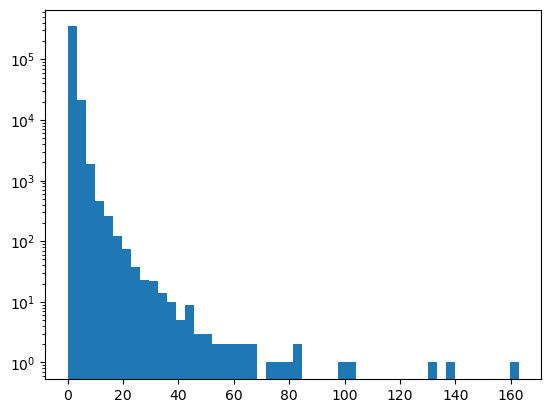

In [6]:
var = deepcopy(df_mc['probe_pfPhoIso03'].values)
print(np.min(var), np.max(var))
plt.yscale('log')
plt.hist(var, bins=50);

0.0 39.06622


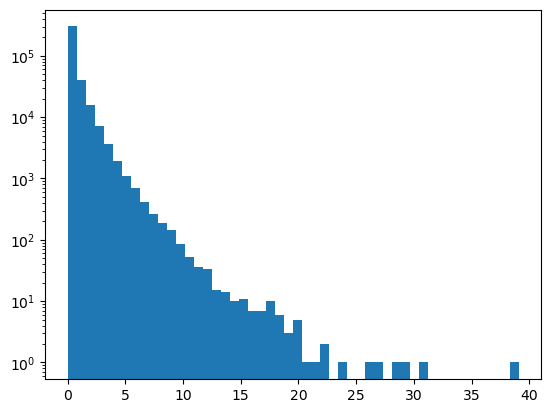

In [7]:
var = deepcopy(df_mc['probe_pfChargedIsoPFPV'].values)
print(np.min(var), np.max(var))
plt.yscale('log')
plt.hist(var, bins=50);

0.0 162.79123
371622
0.002742033571747636
1.2427484


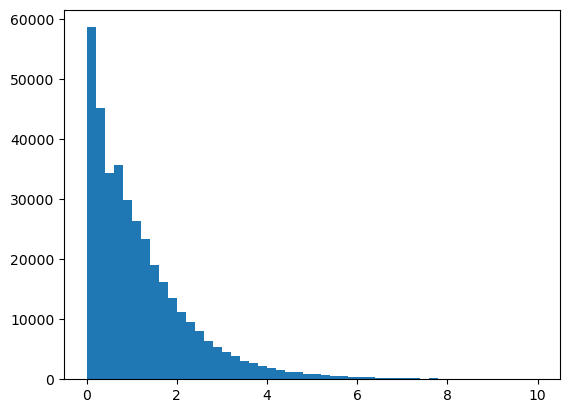

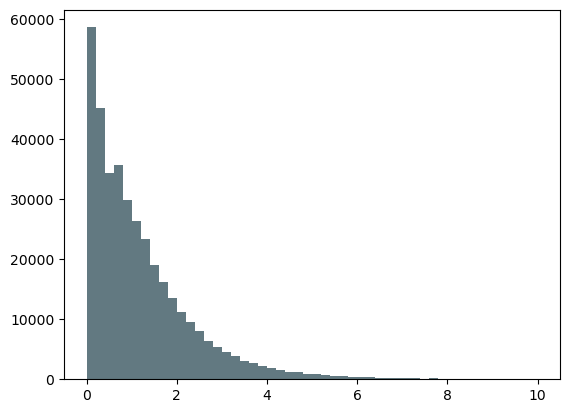

In [5]:
pipe = Pipeline(
    [
        #("min_max_scaler", MinMaxScaler((1, 10))),
        #('box_cox', PowerTransformer(method='box-cox')),
        #("scaler", StandardScaler()),
        #('log', FunctionTransformer(lambda x: np.log(x), inverse_func=lambda x: np.exp(x))),
        #('standard_scaler', StandardScaler()),
        ("none", None)
    ]
)

orig_rng = (0, 10)
var = deepcopy(df_mc['probe_pfPhoIso03'].values)
print(np.min(var), np.max(var))
print(len(var>10))
print(len(var[var>10])/len(var))
print(np.mean(var))
# clip values > 10 to 10
var[var>10] = np.mean(var)
new_var = pipe.fit_transform(var.reshape(-1, 1))
#plt.hist(new_var, bins=50, range=orig_rng);
plt.hist(new_var, bins=50);
plt.show();
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=50, range=orig_rng);
plt.hist(old_var, bins=50, range=orig_rng, alpha=0.3);

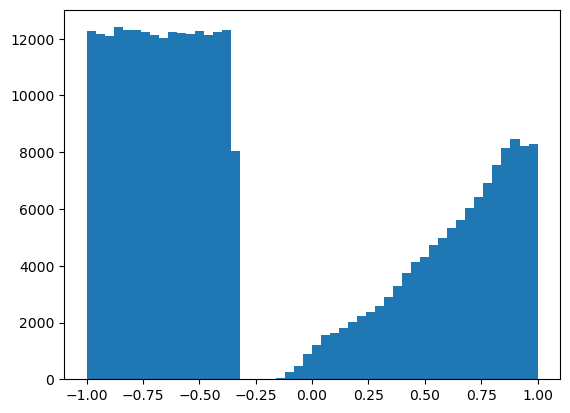

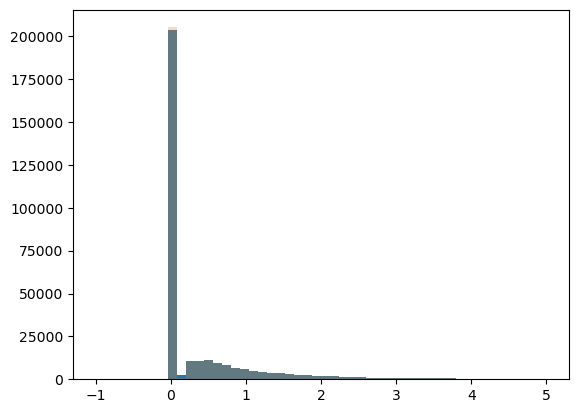

ValueError: cannot reshape array of size 319693 into shape (371622,1)

In [13]:
orig_rng = (-1, 5)
var = deepcopy(df_data['probe_pfChargedIsoPFPV'].values)

pipe = Pipeline(
    [
        #("min_max_scaler", MinMaxScaler((1, 10))),
        #('box_cox', PowerTransformer(method='box-cox')),
        #("scaler", StandardScaler()),
        #('log', FunctionTransformer(lambda x: np.log(x), inverse_func=lambda x: np.exp(x))),
        #('standard_scaler', StandardScaler()),
        #("min_max_scaler", MinMaxScaler((0, 1))),
        #('log', FunctionTransformer(lambda x: np.where(x >= 1, np.log(x), x), inverse_func=lambda x: np.where(x >= 1, np.exp(x), x))),
        ("displacer_pre", Displacer(mask_lower_bound=0., where_to_displace=0.5)),
        #('log', FunctionTransformer(lambda x: np.log(x), inverse_func=lambda x: np.exp(x))),
        ('box_cox', PowerTransformer(method='box-cox')),
        # move min to 0
        ("displacer", Displacer(mask_lower_bound=-1, where_to_displace=0)),
        ("displacer2", Displacer(mask_lower_bound=0.01, where_to_displace=1)),
        ("smearer", Smearer("uniform", mask_upper_bound=1)),
        ("displacer3", Displacer(mask_lower_bound=1., where_to_displace=0.7)),
        #('standard_scaler', StandardScaler()),
        ("min_max_scaler", MinMaxScaler((-1, 1))),
    ]
)

new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=50);
plt.show();
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=50, range=orig_rng);
plt.hist(old_var, bins=50, range=orig_rng, alpha=0.3);
plt.show();

var_mc = deepcopy(df_mc['probe_pfChargedIsoPFPV'].values)
new_var_mc = pipe.transform(var_mc.reshape(-1, 1))
plt.hist(new_var_mc, bins=50);
plt.show();
old_var_mc = pipe.inverse_transform(new_var_mc)
plt.hist(var_mc, bins=50, range=orig_rng);
plt.hist(old_var_mc, bins=50, range=orig_rng, alpha=0.3);
plt.show();

plt.hist(new_var, bins=50);
plt.hist(new_var_mc, bins=50, alpha=0.3);
plt.show();

plt.hist(old_var, bins=50, range=orig_rng);
plt.hist(old_var_mc, bins=50, range=orig_rng, alpha=0.3);
plt.show();

In [40]:
np.log(0)

/tmp/ipykernel_40229/2933082444.py:1: RuntimeWarning: divide by zero encountered in log
  np.log(0)


-inf